In [91]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import marsilea as ma

In [92]:
DETECTION_DIR = "detection"
QUANTIFICATION_DIR = "quantification"
OUT_DIR = "../chapters/4_results_and_discussion/figures/quantification"
detection_tools = [tool_csv[:-4] for tool_csv in os.listdir(DETECTION_DIR)]
quantification_tools = [tool_csv[:-4] for tool_csv in os.listdir(QUANTIFICATION_DIR)]

In [93]:
correct_total_counts = False

In [94]:
def parse_locstring(locstring: str):
    parts = locstring.split(":")
    chrom, coords, strand = parts if len(parts) == 3 else (parts[0], parts[1], ".")
    chrom = chrom[len("circ_"):] if chrom.startswith("circ_") else chrom
    start, end = coords.split("-")
    return chrom, int(start), int(end), strand

In [95]:
def get_tool_data(tool: str, is_detection: bool = True, min_samples=1):
    df = pd.read_csv(os.path.join(DETECTION_DIR if is_detection else QUANTIFICATION_DIR, f"{tool}.{"c" if is_detection else "t"}sv"), sep='\t', index_col=0)
    df.fillna(0, inplace=True)
    if not is_detection:
        df = df.iloc[:, 1:]
    
    df_stats = pd.DataFrame(index=df.index)
    df_stats["n_samples"] = (df>0).sum(axis=1)
    df_stats["total_counts"] = df.sum(axis=1)
    if correct_total_counts:
        df_stats["total_counts"] = df_stats["total_counts"] - df_stats["n_samples"]

    mask = df_stats['n_samples'] > min_samples
    df = df[mask]
    df_stats = df_stats[mask]

    df_loc = pd.DataFrame([parse_locstring(loc) for loc in df.index], columns=["chrom", "start", "end", "strand"], index=df.index)
    df_loc["tool"] = tool

    # Merge df_stats and df_loc
    df_stats = pd.concat([df_stats, df_loc], axis=1)

    return df, df_stats

In [96]:
def get_diff_groups(df_locs: pd.DataFrame, max_diff: int = 0):
    df_diff = df_locs.sort_values(["chrom", "end"])
    df_diff["end_group"] = df_diff.groupby("chrom")["end"].diff().gt(max_diff).cumsum()
    df_diff = df_diff.sort_values(["chrom", "start"])
    df_diff["start_group"] = df_diff.groupby("chrom")["start"].diff().gt(max_diff).cumsum()

    return df_diff

In [97]:
tool_counts = {}
tool_stats = {}

for tool in detection_tools:
    tool_counts[tool], tool_stats[tool] = get_tool_data(tool)

for tool in quantification_tools:
    tool_counts[tool], tool_stats[tool] = get_tool_data(tool, is_detection=False)

df_stats = pd.concat(tool_stats.values(), axis=0)
df_diff = get_diff_groups(df_stats, 1)
df_diff

,n_samples,total_counts,chrom,start,end,strand,tool,end_group,start_group
chr1:3290501-151796866:-,4,4.0,chr1,3290501,151796866,-,find_circ,7016,0
chr1:3435607-3435691:+,2,2.0,chr1,3435607,3435691,+,segemehl,0,1
chr1:3443360-3443455:+,2,2.0,chr1,3443360,3443455,+,segemehl,1,2
chr1:3542317-3542382:-,3,3.0,chr1,3542317,3542382,-,dcc,2,3
chr1:3584318-3584453:+,2,2.0,chr1,3584318,3584453,+,segemehl,3,4
...,...,...,...,...,...,...,...,...,...
chrY:90835262-90835371:-,5,5.0,chrY,90835262,90835371,-,segemehl,151618,151096
chrY:90835262-90835413:-,14,21.0,chrY,90835262,90835413,-,segemehl,151620,151096
chrY:90835270-90835406:-,5,5.0,chrY,90835270,90835406,-,segemehl,151619,151097
chrY:90835923-90836129:-,7,9.0,chrY,90835923,90836129,-,segemehl,151621,151098


In [98]:
df_grouped = df_diff.groupby(["chrom", "start_group", "end_group"]).agg({
    "tool": list,
    "total_counts": list
})

df_grouped = df_grouped[df_grouped["tool"].apply(lambda x: len(set([t for t in x if t in detection_tools]))) >= 4]
df_grouped

tool  \
chrom start_group end_group                                                      
chr1  11          9                     [find_circ, circexplorer2, dcc, ciri2]   
      12          10         [find_circ, circexplorer2, dcc, ciri2, ciriquant]   
      13          9          [find_circ, circexplorer2, dcc, ciri2, ciriquant]   
                  10         [find_circ, circexplorer2, dcc, ciri2, ciriquant]   
      14          11         [find_circ, segemehl, circexplorer2, psirc, dc...   
...                                                                        ...   
chrX  150515      151059      [find_circ, segemehl, circexplorer2, psirc, dcc]   
      150522      151066     [find_circ, segemehl, circexplorer2, psirc, dc...   
      150532      151077     [find_circ, circexplorer2, dcc, ciri2, ciriquant]   
      150620      151164              [find_circ, segemehl, psirc, dcc, ciri2]   
      150759      151300     [find_circ, segemehl, circexplorer2, psirc, dc...   

                                                             total_counts  
chrom start_group end_group                                                
chr1  11          9                                  [3.0, 2.0, 2.0, 2.0]  
      12          10                         [5.0, 5.0, 5.0, 5.0, 0.2363]  
      13          9                          [7.0, 5.0, 5.0, 7.0, 0.2628]  
                  10                          [6.0, 6.0, 6.0, 6.0, 0.236]  
      14          11         [4.0, 5.0, 4.0, 5.320644830000001, 4.0, 3.0]  
...                                                                   ...  
chrX  150515      151059                 [2.0, 2.0, 2.0, 17.5785966, 2.0]  
      150522      151066          [9.0, 10.0, 5.0, 27.5155671, 5.0, 10.0]  
      150532      151077                     [2.0, 2.0, 2.0, 2.0, 0.0675]  
      150620      151164           [22.0, 24.0, 31.707543781, 20.0, 23.0]  
      150759      151300     [2.0, 2.0, 2.0, 4.321852700000001, 2.0, 2.0]  

[9715 rows x 2 columns]

In [99]:
df_grouped["count_dict"] = df_grouped.apply(lambda row: dict(zip(row["tool"], row["total_counts"])), axis=1)
df_grouped.drop(columns=["tool", "total_counts"], inplace=True)

# Explode the count_dict
df_grouped = df_grouped["count_dict"].apply(pd.Series)
df_detection = df_grouped[detection_tools]
df_quantification = df_grouped[quantification_tools]
df_agg = pd.DataFrame(index=df_grouped.index)
df_agg["sum"]    = df_detection.sum(axis=1)
df_agg["min"]    = df_detection.min(axis=1)
df_agg["max"]    = df_detection.max(axis=1)
df_agg["median"] = df_detection.median(axis=1)

df_plot = pd.concat([df_detection, df_agg, df_quantification], axis=1)
df_plot

find_circ  segemehl   dcc  circexplorer2  ciri2  \
chrom start_group end_group                                                    
chr1  11          9                3.0       NaN   2.0            2.0    2.0   
      12          10               5.0       NaN   5.0            5.0    5.0   
      13          9                7.0       NaN   5.0            5.0    7.0   
                  10               6.0       NaN   6.0            6.0    6.0   
      14          11               4.0       5.0   4.0            4.0    3.0   
...                                ...       ...   ...            ...    ...   
chrX  150515      151059           2.0       2.0   2.0            2.0    NaN   
      150522      151066           9.0      10.0   5.0            5.0   10.0   
      150532      151077           2.0       NaN   2.0            2.0    2.0   
      150620      151164          22.0      24.0  20.0            NaN   23.0   
      150759      151300           2.0       2.0   2.0            2.0    2.0   

                              sum   min   max  median  ciriquant      psirc  
chrom start_group end_group                                                  
chr1  11          9           9.0   2.0   3.0     2.0        NaN        NaN  
      12          10         20.0   5.0   5.0     5.0     0.2363        NaN  
      13          9          24.0   5.0   7.0     6.0     0.2628        NaN  
                  10         24.0   6.0   6.0     6.0     0.2360        NaN  
      14          11         20.0   3.0   5.0     4.0        NaN   5.320645  
...                           ...   ...   ...     ...        ...        ...  
chrX  150515      151059      8.0   2.0   2.0     2.0        NaN  17.578597  
      150522      151066     39.0   5.0  10.0     9.0        NaN  27.515567  
      150532      151077      8.0   2.0   2.0     2.0     0.0675        NaN  
      150620      151164     89.0  20.0  24.0    22.5        NaN  31.707544  
      150759      151300     10.0   2.0   2.0     2.0        NaN   4.321853  

[9715 rows x 11 columns]

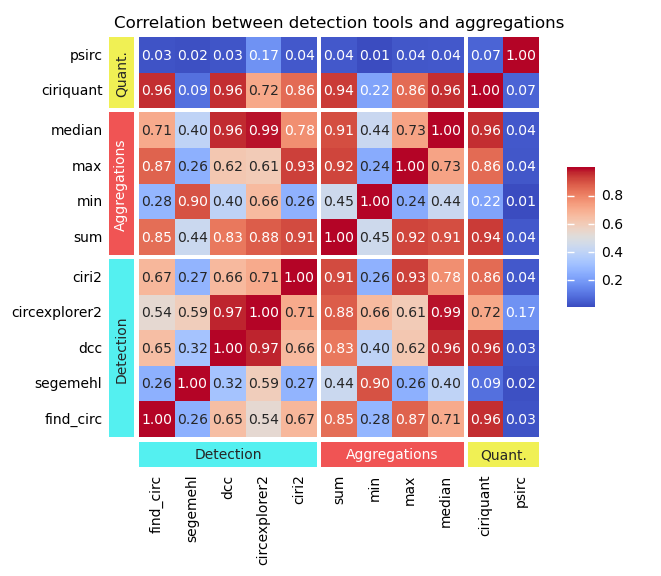

In [100]:
# Calculate the correlation matrix
corr = df_plot.corr()

# Invert column order
corr = corr.iloc[::-1]

h = ma.Heatmap(corr, annot=True, fmt=".2f")

categories = ["Detection", "Aggregations", "Quant."]
colors = ["#54F0F0", "#F05454", "#F0F054"]

h.group_cols([categories[0] if group in detection_tools else categories[2] if group in quantification_tools else categories[1] for group in corr.columns], order=categories)
h.group_rows([categories[0] if group in detection_tools else categories[2] if group in quantification_tools else categories[1] for group in corr.index], order=categories[::-1])
h.add_bottom(ma.plotter.Chunk(categories, fill_colors=colors), pad=0.05)
h.add_bottom(ma.plotter.Labels(corr.columns), pad=0.05)
h.add_left(ma.plotter.Chunk(categories[::-1], fill_colors=colors[::-1]), pad=0.05)
h.add_left(ma.plotter.Labels(corr.index), pad=0.05)

h.add_legends("right")
h.add_title("Correlation between detection tools and aggregations")
h.save(os.path.join(OUT_DIR, "correlation_heatmap.png"))